In [101]:
import cv2
import math
import sys
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN

In [102]:
# Load image (2560*1800)
original_img = cv2.imread('3_1_q010.tif', cv2.IMREAD_GRAYSCALE)

In [103]:
# Cut scale bar from the image and make it binary
def cut_scale_bar(img):
    '''
    Returns a row of binary number representing scale bar
    '''
    scale_bar = img[1800:-1, 1800:-1]
    _,thresh1 = cv2.threshold(scale_bar,80,255,cv2.THRESH_BINARY)
    plt.imshow(thresh1,cmap="gray")
    return thresh1[1].tolist()


# Calculate the translation between scale bar & pixels
def dist_btw_scale_bar(lst, value):
    '''
    Args:
        lst: a row in the image that cuts thru the scale bar
        value: usually = 255 if white

    Returns:
        length of distance between scale bar in pixels
    '''
    # find first occurance of white scale bar
    j = lst.index(value)
    # find last occurance of white scale bar
    lst.reverse()
    i = lst.index(value)

    return (len(lst) - i - 1) - j

def translate_pixel_to_nm(length_pixel, scale_bar_length):
    '''
    Args:
        length_pixel: from `dist_btw_scale_bar`, the number of pixels between scale bar
        scale_bar_length: actual scale bar length from SEM

    Returns:
        physical length of each pixel in nanometer  
    '''
    return length_pixel / scale_bar_length




0.612


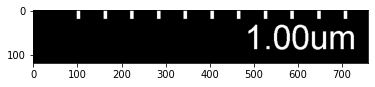

In [104]:
thresh_row = cut_scale_bar(original_img)
length_pixel = dist_btw_scale_bar(thresh_row,255)
pixel_to_nm = translate_pixel_to_nm(length_pixel, 1E3)
print(pixel_to_nm)


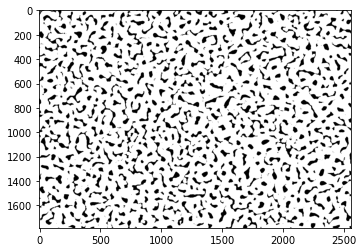

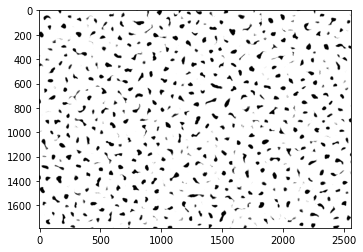

In [105]:
# load img and crop away scale bar
cropped_image = original_img[0:1785, :]

# binary thresholding, change threshold if needed
ret,thresh1 = cv2.threshold(cropped_image,80,255,cv2.THRESH_BINARY)


# adaptive thresholding
kernel = np.ones((5, 5), np.uint8) 
ret3,binary_img = cv2.threshold(cropped_image,80,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
img_adaptive = cv2.dilate(binary_img, kernel, iterations=1) 

plt.imshow(img_adaptive,cmap="gray")
plt.show()
plt.imshow(thresh1,cmap="gray")
plt.show()


In [106]:

sum_row = []
for row in img_adaptive:
    sum_row.append(sum(row))

# Total percentage area occupied by the holes 
1-sum(sum_row)/255/(2560*1785)


0.1761847864145658

In [107]:

def find_clusters(img, eps=8, min_samples=30):
    '''
    Finds clusters with DBSCAN algorithm.
    Args: img=thresholded binary image
    Returns: a dictionary with keys=#cluster, values=all pixel coord within the cluster

    '''
    
    # Find coordinates of dark pixels
    dark_spots_coords = np.column_stack(np.where(img == 0))
    
    # Apply DBSCAN
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    dbscan.fit(dark_spots_coords)
    
    # Initialize dictionary to store cluster centroids
    cluster_centers = {}
    
    # Save label and coord info to the dictionary
    for label, coord in zip(dbscan.labels_, dark_spots_coords):
        if label != -1:  # Ignore noise points
            if label not in cluster_centers:
                cluster_centers[label] = [coord]

            else:
                cluster_centers[label].append(coord)

    return cluster_centers

def remove_small_holes(cluster_centers, min_area=500):
    '''
    Hard coded to remove all holes with diameters smaller than 40nm, as they are most
    likely artifects from adaptive thresholding.

    Returns a dictionary similar to previous func, but removes small holes
    '''

    # Make a copy of the dictionary so dict doesn't complain
    cluster_center_copy = {}

    # getting rid of holes with effective diamter < 40nm
    for label,coords in cluster_centers.items():
        if len(coords) >= min_area:
            cluster_center_copy[label] = coords

    return cluster_center_copy, len(cluster_center_copy)


def annotate_image_with_labels(cluster_large_holes):
    '''
    centroid_x, centroid_y: two lists with x and y coordinates of the centroid for each
    hole
    '''

    centroids_x = []
    centroids_y = []

    for label, coords in cluster_large_holes.items():

        center = np.mean(coords, axis=0).astype(int)
        x, y = center[0], center[1]

        cv2.putText(original_img, str(label), (y, x), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color=255, thickness=2)
        
        centroids_x.append(center[0])
        centroids_y.append(center[1])

    # Display the annotated image
    cv2.imshow('Annotated Image', original_img)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

    return centroids_x, centroids_y



In [108]:
cluster_centers = find_clusters(img_adaptive)


In [109]:
cluster_large_holes,num_holes = remove_small_holes(cluster_centers)


In [110]:
cen_x,cen_y = annotate_image_with_labels(cluster_large_holes)


QObject::moveToThread: Current thread (0x5577b2210ae0) is not the object's thread (0x5577bb2543d0).
Cannot move to target thread (0x5577b2210ae0)

QObject::moveToThread: Current thread (0x5577b2210ae0) is not the object's thread (0x5577bb2543d0).
Cannot move to target thread (0x5577b2210ae0)

QObject::moveToThread: Current thread (0x5577b2210ae0) is not the object's thread (0x5577bb2543d0).
Cannot move to target thread (0x5577b2210ae0)

QObject::moveToThread: Current thread (0x5577b2210ae0) is not the object's thread (0x5577bb2543d0).
Cannot move to target thread (0x5577b2210ae0)

QObject::moveToThread: Current thread (0x5577b2210ae0) is not the object's thread (0x5577bb2543d0).
Cannot move to target thread (0x5577b2210ae0)

QObject::moveToThread: Current thread (0x5577b2210ae0) is not the object's thread (0x5577bb2543d0).
Cannot move to target thread (0x5577b2210ae0)

QObject::moveToThread: Current thread (0x5577b2210ae0) is not the object's thread (0x5577bb2543d0).
Cannot move to tar

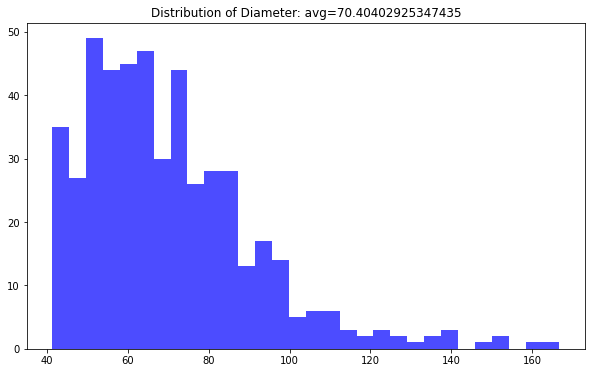

In [111]:
cluster_size = []
diameter = []

for label,coords in cluster_large_holes.items():
    cluster_size.append(len(cluster_large_holes[label])/pixel_to_nm**2)
    diameter.append(2*math.sqrt(len(cluster_large_holes[label])/pixel_to_nm**2/3.14))

plt.figure(figsize=(10, 6))
plt.hist(diameter, bins=30, alpha=0.7, color='blue')
plt.title('Distribution of Diameter: avg=' + str(np.average(diameter)))
plt.show()

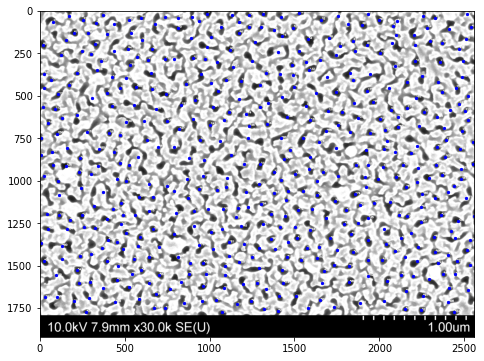

number of holes in this area: 485


In [112]:
# Sanity check: make sure that the centroid is correctly located at the centre of each cluster
plt.figure(figsize=(10,6))
plt.imshow(original_img, cmap='gray')
plt.scatter(cen_y,cen_x,s=5,c="b")
plt.show()
print("number of holes in this area: " + str(num_holes))

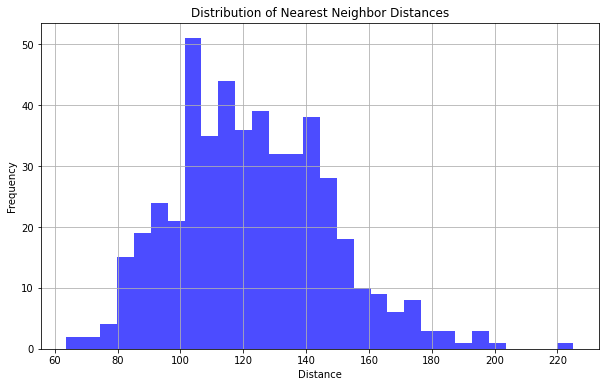

In [113]:
from scipy.spatial import KDTree

dots = np.column_stack((cen_x, cen_y))

# Use KDTree for efficient nearest neighbor search
tree = KDTree(dots)

# Find the nearest neighbor for each dot (excluding itself)
distances, _ = tree.query(dots, k=6)  # k=2 to get the first nearest neighbor, excluding the point itself

# distances[:,1] contains the distance to the nearest neighbor
nearest_neighbor_distances = distances[:, 1]/pixel_to_nm

# Plotting the distribution of nearest neighbor distances
plt.figure(figsize=(10, 6))
plt.hist(nearest_neighbor_distances, bins=30, alpha=0.7, color='blue')
plt.title('Distribution of Nearest Neighbor Distances')
plt.xlabel('Distance')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

